In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime 
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.utils import shuffle
import statsmodels.api as sm

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# Load Dataset with all columns
# Making the data columns datetime objects with the parse_dates attribute
bikeshare_machine = pd.read_csv('/Users/matthewcassi/Documents/Bike-Sharing-Dataset/less_bikeshare_lat_lon.csv', 
                        parse_dates=['Start date', 'End date', 'start_date_short', 'end_date_short'])
# Removing the Unnamed column
bikeshare_machine.drop('Unnamed: 0', 1, inplace=True)

In [4]:
# creating a list of columns which will be used to create the list of columns to keep for the machine
# learning piece
list(bikeshare_machine.columns)

['Start date',
 'End date',
 'start_station',
 'start_station_code',
 'end_station',
 'end_station_code',
 'Member Type',
 'start_date_short',
 'end_date_short',
 'time_diff',
 'season',
 'mnth',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'hum',
 'windspeed',
 'start_lat',
 'start_lon',
 'end_lat',
 'end_lon',
 'miles']

In [5]:
# Selecting the columns that are needed for the analysis. Remove start/end stations
included_cols = ['Member Type',
                 'time_diff',
                 'season',
                 'mnth',
                 'holiday',
                 'weekday',
                 'workingday',
                 'weathersit',
                 'temp',
                 'hum',
                 'windspeed',
                 'miles']
# Subsetting the dataset so that only the columns above are included
bikeshare_machine = bikeshare_machine[included_cols]
bikeshare_machine.head()

,Member Type,time_diff,season,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,miles
0,Registered,1.833,2,3,0,4,1,3,0.268333,0.918333,0.217646,0.238743
1,Registered,3.317,2,3,0,4,1,3,0.268333,0.918333,0.217646,0.659533
2,Registered,5.733,2,3,0,4,1,3,0.268333,0.918333,0.217646,0.691996
3,Registered,8.700,2,3,0,4,1,3,0.268333,0.918333,0.217646,1.453796
4,Registered,7.850,2,3,0,4,1,3,0.268333,0.918333,0.217646,1.351053


In [7]:
# Make categorical data for columns like month, holiday, etc.
bikeshare_machine['season'] = bikeshare_machine['season'].astype('category')
bikeshare_machine['mnth'] = bikeshare_machine['mnth'].astype('category')
bikeshare_machine['holiday'] = bikeshare_machine['holiday'].astype('category')
bikeshare_machine['weekday'] = bikeshare_machine['weekday'].astype('category')
bikeshare_machine['workingday'] = bikeshare_machine['workingday'].astype('category')
bikeshare_machine['weathersit'] = bikeshare_machine['weathersit'].astype('category')
bikeshare_machine['Member Type'] = bikeshare_machine['Member Type'].astype('category')

In [8]:
# Update columns names for the dataset
col_names = ['member_type','time_diff','season','month','holiday',
             'weekday','work_day','weather_cat','temperature','humidity','windspeed','miles']
bikeshare_machine.columns = col_names

In [9]:
# Standardization of windspeed, humidity, and temperature were not all the same
# Values were changed back to their original values (not scaled)
tmin = -8
tmax = 39
hum_max = 100
wind_max = 67
bikeshare_machine['temp'] = bikeshare_machine['temperature'] * (tmax - tmin) + tmin
bikeshare_machine['hum'] = bikeshare_machine['humidity'] * 100
bikeshare_machine['wind'] = bikeshare_machine['windspeed'] * 67

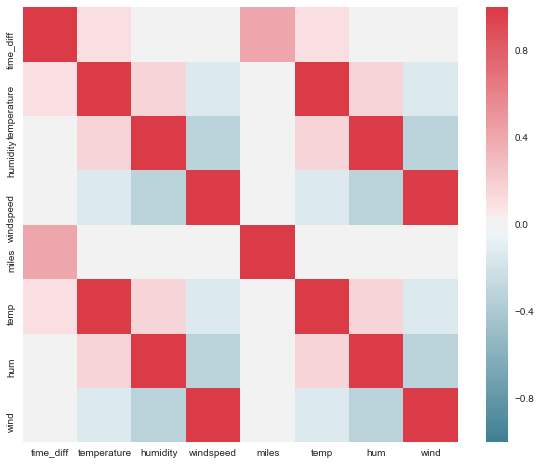

In [10]:
# Checking the correlations between continuous variables
corr = bikeshare_machine.corr()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [11]:
# Turn categorical data into dummy variables. Dropping first dummy for the category variables that have 2 labels
bikeshare_machine = pd.get_dummies(bikeshare_machine, 
                                 columns=['member_type','holiday','work_day'], drop_first=True)
# Turning categorical data into dummy variables. Not dropping the first dummy for categorical data with more
# than 2 labels
bikeshare_machine = pd.get_dummies(bikeshare_machine, 
                                 columns=['season','month','weekday','weather_cat'])
bikeshare_machine.head()

,time_diff,temperature,humidity,windspeed,miles,temp,hum,wind,member_type_Registered,holiday_1,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weather_cat_1,weather_cat_2,weather_cat_3
0,1.833,0.268333,0.918333,0.217646,0.238743,4.611651,91.8333,14.582282,1,0,...,0,0,0,0,1,0,0,0,0,1
1,3.317,0.268333,0.918333,0.217646,0.659533,4.611651,91.8333,14.582282,1,0,...,0,0,0,0,1,0,0,0,0,1
2,5.733,0.268333,0.918333,0.217646,0.691996,4.611651,91.8333,14.582282,1,0,...,0,0,0,0,1,0,0,0,0,1
3,8.700,0.268333,0.918333,0.217646,1.453796,4.611651,91.8333,14.582282,1,0,...,0,0,0,0,1,0,0,0,0,1
4,7.850,0.268333,0.918333,0.217646,1.351053,4.611651,91.8333,14.582282,1,0,...,0,0,0,0,1,0,0,0,0,1


In [12]:
bikeshare_machine = shuffle(bikeshare_machine)
bikeshare_machine.head()

,time_diff,temperature,humidity,windspeed,miles,temp,hum,wind,member_type_Registered,holiday_1,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weather_cat_1,weather_cat_2,weather_cat_3
441032,17.583,0.507500,0.695000,0.178483,1.512253,15.852500,69.5000,11.958361,1,0,...,1,0,0,0,0,0,0,1,0,0
305209,27.550,0.528333,0.631667,0.074637,2.661033,16.831651,63.1667,5.000712,1,0,...,1,0,0,0,0,0,0,1,0,0
1117638,12.067,0.527500,0.567500,0.441563,1.190652,16.792500,56.7500,29.584721,1,0,...,0,0,0,0,1,0,0,1,0,0
826562,5.467,0.395000,0.758750,0.057225,0.585465,10.565000,75.8750,3.834075,1,0,...,0,1,0,0,0,0,0,1,0,0
90700,10.350,0.203478,0.793043,0.123300,0.714558,1.563466,79.3043,8.261100,1,0,...,0,0,0,0,0,1,0,0,1,0


### Model 1 - Remove Some Variables that are correlated

In [13]:
# Leave workday, drop weekdays, leave season, drop month
# Workday overlaps with workday/not workday and months overlap with seasons
remove_cols = ['weekday_0', 'weekday_1','weekday_2','weekday_3','weekday_4','weekday_5','weekday_6', 
              'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9',
              'month_10','month_11','month_12','temperature','humidity','windspeed', 'time_diff']
X1 = np.matrix(bikeshare_machine.drop(remove_cols, 1))
y1 = bikeshare_machine['time_diff']

In [14]:
# Split the data into training and testing sets and check the shape
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.25, random_state=17)
X1_train.shape, X1_test.shape, y1_train.shape, y1_test.shape

((914885, 14), (304962, 14), (914885,), (304962,))

In [15]:
# Fit model
model1 = LinearRegression()
model1.fit(X1_train, y1_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [16]:
pred1 = model1.predict(X1_test)
cvscores_model1 = cross_val_score(model1, X1_train, y1_train, cv=5)
model1_r = model1.score(X1_test, y1_test)
model1_mse = mean_squared_error(y1_test, pred1)
model1_rmse = np.sqrt(model1_mse)
adjustedr1 = 1 - (1-model1_r)*(len(y1_test)-1)/(len(y1_test)-X1_test.shape[1]-1)

In [17]:
cvscores_model1, model1_r, adjustedr1, model1_mse, model1_rmse

(array([ 0.37271965,  0.36932336,  0.3737934 ,  0.37356351,  0.37634451]),
 0.37016120078481829,
 0.37013228512672358,
 86.471324791119514,
 9.2989959023068458)

In [18]:
model1_sm = sm.OLS(y1_train, X1_train).fit()
model1_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              time_diff   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                 4.539e+04
Date:                Tue, 05 Dec 2017   Prob (F-statistic):               0.00
Time:                        18:53:05   Log-Likelihood:            -3.3349e+06
No. Observations:              914885   AIC:                         6.670e+06
Df Residuals:                  914872   BIC:                         6.670e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             6.3326      0.013    487.386      0.000       6.307       6.358
x2             0.0678      0.002     33.370      0.000       0.064       0.072
x3             0.0006      0.001      0.582      0.561      -0.001       0.002
x4            -0.0131      0.002     -6.259      0.000      -0.017      -0.009
x5           -13.4933      0.027   -505.268      0.000     -13.546     -13.441
x6            -0.5037      0.067     -7.545      0.000      -0.635      -0.373
x7            -1.5272      0.022    -68.400      0.000      -1.571      -1.483
x8             7.5671      0.042    182.047      0.000       7.486       7.649
x9             8.2384      0.046    180.854      0.000       8.149       8.328
x10            7.3861      0.049    150.859      0.000       7.290       7.482
x11            7.4862      0.044    169.727      0.000       7.400       7.573
x12           10.7302      0.042    254.718      0.000      10.648      10.813
x13           10.3505      0.053    194.780      0.000      10.246      10.455
x14            9.5971      0.091    105.368      0.000       9.419       9.776
==============================================================================
Omnibus:                   569630.903   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          7384752.990
Skew:                           2.831   Prob(JB):                         0.00
Kurtosis:                      15.715   Cond. No.                     5.60e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.34e-24. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Model 2 - Try reverse of Model 1

In [19]:
# Drop workday, leave weekdays, drop season, leave month
# Workday overlaps with workday/not workday and months overlap with seasons
remove_cols = ['work_day_1','season_1', 'season_2', 'season_3', 'season_4',
               'temperature','humidity','windspeed', 'time_diff']
X2 = bikeshare_machine.drop(remove_cols, 1)
y2 = bikeshare_machine['time_diff']

In [20]:
# Split the data into training and testing sets and check the shape
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.25, random_state=17)
X2_train.shape, X2_test.shape, y2_train.shape, y2_test.shape

((914885, 28), (304962, 28), (914885,), (304962,))

In [21]:
# Fit model
model2 = LinearRegression()
model2.fit(X2_train, y2_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [22]:
pred2 = model2.predict(X2_test)
cvscores_model2 = cross_val_score(model2, X2_train, y2_train, cv=5)
model2_r = model2.score(X2_test, y2_test)
model2_mse = mean_squared_error(y2_test, pred2)
model2_rmse = np.sqrt(model2_mse)
adjustedr2 = 1 - (1-model2_r)*(len(y2_test)-1)/(len(y2_test)-X2_test.shape[1]-1)

In [23]:
cvscores_model2, model2_r, adjustedr2, model2_mse, model2_rmse

(array([ 0.37346838,  0.37017261,  0.3745443 ,  0.37419877,  0.37726756]),
 0.37098459273333761,
 0.37092683436870189,
 86.358280322122795,
 9.2929155985687721)

In [24]:
# Use statsmodel to check the statistical side of the model
model2_sm = sm.OLS(y2_train, X2_train).fit()
model2_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              time_diff   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                 2.186e+04
Date:                Tue, 05 Dec 2017   Prob (F-statistic):               0.00
Time:                        18:53:53   Log-Likelihood:            -3.3343e+06
No. Observations:              914885   AIC:                         6.669e+06
Df Residuals:                  914859   BIC:                         6.669e+06
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
miles                      6.3258      0.013    487.018      0.000       6.300       6.351
temp                       0.0815      0.003     27.858      0.000       0.076       0.087
hum                       -0.0058      0.001     -5.505      0.000      -0.008      -0.004
wind                      -0.0262      0.002    -12.146      0.000      -0.030      -0.022
member_type_Registered   -13.4501      0.027   -503.077      0.000     -13.502     -13.398
holiday_1                  0.8460      0.068     12.369      0.000       0.712       0.980
month_1                    2.4210      0.044     54.688      0.000       2.334       2.508
month_2                    2.3624      0.038     61.852      0.000       2.288       2.437
month_3                    2.9947      0.029    102.243      0.000       2.937       3.052
month_4                    3.7741      0.043     87.792      0.000       3.690       3.858
month_5                    3.3014      0.040     82.905      0.000       3.223       3.379
month_6                    2.2564      0.045     50.344      0.000       2.169       2.344
month_7                    1.9437      0.051     37.951      0.000       1.843       2.044
month_8                    2.2242      0.047     47.633      0.000       2.133       2.316
month_9                    2.2321      0.042     52.780      0.000       2.149       2.315
month_10                   2.5488      0.037     68.077      0.000       2.475       2.622
month_11                   2.5419      0.042     61.143      0.000       2.460       2.623
month_12                   2.1569      0.046     46.935      0.000       2.067       2.247
weekday_0                  5.3853      0.035    153.719      0.000       5.317       5.454
weekday_1                  4.1072      0.036    113.645      0.000       4.036       4.178
weekday_2                  3.8419      0.034    111.698      0.000       3.774       3.909
weekday_3                  3.8039      0.036    106.921      0.000       3.734       3.874
weekday_4                  3.9248      0.035    110.741      0.000       3.855       3.994
weekday_5                  4.1017      0.033    124.610      0.000       4.037       4.166
weekday_6                  5.5929      0.033    168.656      0.000       5.528       5.658
weather_cat_1             10.6519      0.047    225.483      0.000      10.559      10.744
weather_cat_2             10.3375      0.058    177.605      0.000      10.223      10.452
weather_cat_3              9.7683      0.095    102.681      0.000       9.582       9.955
==============================================================================
Omnibus:                   569424.653   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          7378778.275
Skew:                    

### Model 3 - All variables

In [25]:
# Keep all but time_diff
X3 = bikeshare_machine.drop('time_diff', 1)
y3 = bikeshare_machine['time_diff']

In [26]:
# Split the data into training and testing sets and check the shape
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size = 0.25, random_state=17)
X3_train.shape, X3_test.shape, y3_train.shape, y3_test.shape

((914885, 36), (304962, 36), (914885,), (304962,))

In [27]:
# Fit model
model3 = LinearRegression()
model3.fit(X3_train, y3_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [28]:
pred3 = model3.predict(X3_test)
cvscores_model3 = cross_val_score(model3, X3_train, y3_train, cv=5)
model3_r = model3.score(X3_test, y3_test)
model3_mse = mean_squared_error(y3_test, pred3)
model3_rmse = np.sqrt(model3_mse)
adjustedr3 = 1 - (1-model3_r)*(len(y3_test)-1)/(len(y3_test)-X3_test.shape[1]-1)

In [29]:
cvscores_model3, model3_r, adjustedr3, model3_mse, model3_rmse

(array([ 0.37347279,  0.37017545,  0.37454757,  0.37420571,  0.37726468]),
 0.37100423249330816,
 0.37092997210918011,
 86.355583955901238,
 9.2927705209964824)

In [30]:
# Use statsmodel to check the statistical side of the model
model3_sm = sm.OLS(y3_train, X3_train).fit()
model3_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              time_diff   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                 1.952e+04
Date:                Tue, 05 Dec 2017   Prob (F-statistic):               0.00
Time:                        18:54:23   Log-Likelihood:            -3.3343e+06
No. Observations:              914885   AIC:                         6.669e+06
Df Residuals:                  914856   BIC:                         6.669e+06
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
temperature                3.0753      0.017    183.125      0.000       3.042       3.108
humidity               -5.698e-05   1.05e-05     -5.450      0.000   -7.75e-05   -3.65e-05
windspeed                 -0.0004   3.22e-05    -12.201      0.000      -0.000      -0.000
miles                      6.3259      0.013    487.025      0.000       6.300       6.351
temp                       0.0159      0.003      5.253      0.000       0.010       0.022
hum                       -0.0057      0.001     -5.450      0.000      -0.008      -0.004
wind                      -0.0264      0.002    -12.201      0.000      -0.031      -0.022
member_type_Registered   -13.4488      0.027   -502.942      0.000     -13.501     -13.396
holiday_1                  3.7192      0.054     68.572      0.000       3.613       3.825
work_day_1                 2.8791      0.030     97.556      0.000       2.821       2.937
season_1                   4.4520      0.047     93.905      0.000       4.359       4.545
season_2                   4.5654      0.044    104.641      0.000       4.480       4.651
season_3                   4.6136      0.047     98.771      0.000       4.522       4.705
season_4                   4.4343      0.052     84.707      0.000       4.332       4.537
month_1                    1.4271      0.059     24.195      0.000       1.312       1.543
month_2                    1.3692      0.055     25.047      0.000       1.262       1.476
month_3                    1.9595      0.041     48.364      0.000       1.880       2.039
month_4                    2.6692      0.054     49.480      0.000       2.563       2.775
month_5                    2.1957      0.051     42.806      0.000       2.095       2.296
month_6                    1.1355      0.049     23.215      0.000       1.040       1.231
month_7                    0.7916      0.063     12.623      0.000       0.669       0.914
month_8                    1.0716      0.059     18.086      0.000       0.955       1.188
month_9                    1.1293      0.049     22.964      0.000       1.033       1.226
month_10                   1.5738      0.059     26.892      0.000       1.459       1.688
month_11                   1.5669      0.062     25.420      0.000       1.446       1.688
month_12                   1.1761      0.055     21.358      0.000       1.068       1.284
weekday_0                  5.6300      0.038    148.446      0.000       5.556       5.704
weekday_1                  1.4727      0.025     59.090      0.000       1.424       1.522
weekday_2                  1.2064      0.026     46.860      0.000       1.156       1.257
weekday_3                  1.1660      0.027     43.941      0.000       1.114       1.218
weekday_4                  1.2870      0.026     49.258      0.000       1.236  

### Model 4 - Ridge with Round 1

In [31]:
# Fit the model with 5 folds
alpha = np.arange(0.0001, 20, 25)
param_grid = {'alpha': alpha}
ridge1 = Ridge(fit_intercept=True)
ridge1_gs = GridSearchCV(ridge1, param_grid, cv=5)
ridge1_gs.fit(X1_train, y1_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([ 0.0001])}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

In [32]:
pred4 = ridge1_gs.predict(X1_test)
ridge1_r = ridge1_gs.score(X1_test, y1_test)
ridge1_mse = mean_squared_error(y1_test, pred4)
ridge1_rmse = np.sqrt(ridge1_mse)
adjustedr4 = 1 - (1-ridge1_r)*(len(y1_test)-1)/(len(y1_test)-X1_test.shape[1]-1)

In [33]:
ridge1_r, ridge1_mse, ridge1_rmse, adjustedr4

(0.37016120078620007,
 86.471324790929799,
 9.298995902296646,
 0.37013228512810536)

### Ridge with Round 2

In [34]:
# Fit the model with 5 folds
alpha = np.arange(0.0001, 20, 25)
param_grid = {'alpha': alpha}
ridge2 = Ridge(fit_intercept=True)
ridge2_gs = GridSearchCV(ridge2, param_grid, cv=5)
ridge2_gs.fit(X2_train, y2_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([ 0.0001])}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

In [35]:
pred5 = ridge2_gs.predict(X2_test)
ridge2_r = ridge2_gs.score(X2_test, y2_test)
ridge2_mse = mean_squared_error(y2_test, pred5)
ridge2_rmse = np.sqrt(ridge2_mse)
adjustedr5 = 1 - (1-ridge2_r)*(len(y2_test)-1)/(len(y2_test)-X2_test.shape[1]-1)

In [36]:
ridge2_r, ridge2_mse, ridge2_rmse, adjustedr5

(0.37098459273489537,
 86.358280321908936,
 9.2929155985572649,
 0.37092683437025975)

### Ridge with all data

In [37]:
# Fit the model with 5 folds
alpha = np.arange(0.0001, 20, 25)
param_grid = {'alpha': alpha}
ridge3 = Ridge(fit_intercept=True)
ridge3_gs = GridSearchCV(ridge3, param_grid, cv=5)
ridge3_gs.fit(X3_train, y3_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([ 0.0001])}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

In [38]:
pred6 = ridge3_gs.predict(X3_test)
ridge3_r = ridge3_gs.score(X3_test, y3_test)
ridge3_mse = mean_squared_error(y3_test, pred6)
ridge3_rmse = np.sqrt(ridge3_mse)
adjustedr6 = 1 - (1-ridge3_r)*(len(y3_test)-1)/(len(y3_test)-X3_test.shape[1]-1)

In [39]:
ridge3_r, ridge3_mse, ridge3_rmse, adjustedr6

(0.37100423249431969,
 86.35558395576237,
 9.292770520989011,
 0.37092997211019174)